In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import cv2
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.__version__

'0.3.1'

In [3]:
seed = 1

cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

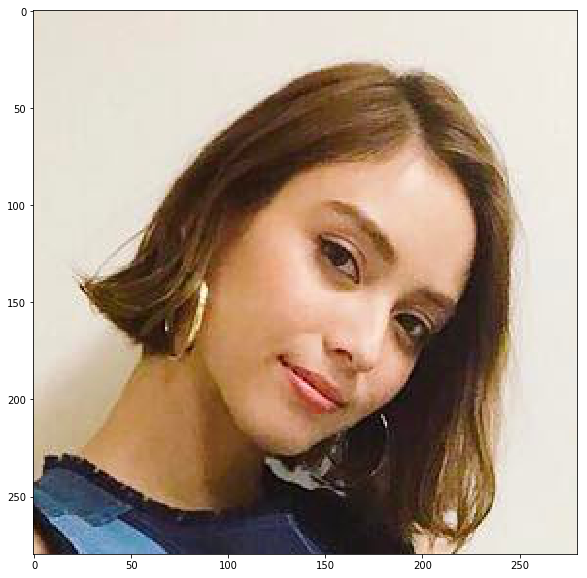

In [4]:
# hr
hr_img = cv2.imread('./data/karen/karen_hr.jpg')
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
hr_img = hr_img[80:360, 380:660]
plt.figure(figsize = (10, 10))
plt.imshow(hr_img)
plt.show()

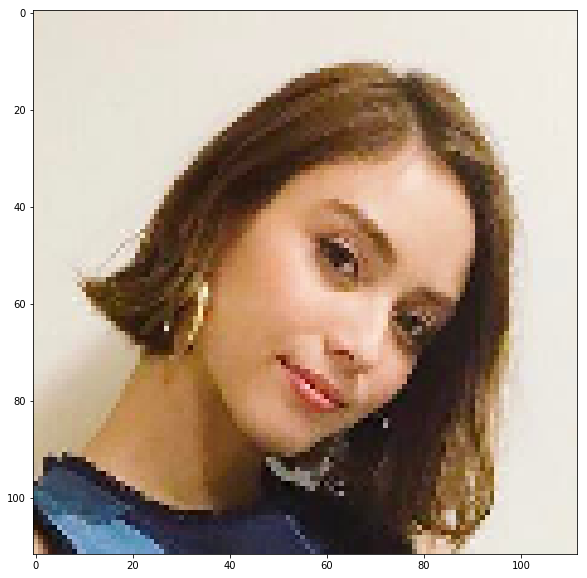

In [5]:
# lr
lr_img = cv2.resize(hr_img, None, fx = 0.4, fy = 0.4, interpolation = cv2.INTER_CUBIC)
plt.figure(figsize = (10, 10))
plt.imshow(lr_img)
plt.show()

In [6]:
lr_img.shape

(112, 112, 3)

In [7]:
def createDownscaledImage (hr_img, scalingFactor = 0.1):
    return cv2.resize(hr_img, None, fx = scalingFactor, fy = scalingFactor, interpolation = cv2.INTER_CUBIC)

def showImage (img):
    show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize = (10, 10))
    plt.imshow(show_img)
    plt.show()

def imshow (output, figsize=(10, 10)):
    plt_img = np.clip(output.data.numpy()[0].transpose((1, 2, 0)), 0, 1)
    plt.figure(figsize = (10, 10))
    plt.imshow(plt_img)
    plt.show()

In [8]:
class DeepImagePriorSR(nn.Module):
    def __init__(self, input_noise, width, height, down):
        super(DeepImagePriorSR, self).__init__()

        self.input_noise = input_noise
        self.width = width
        self.height = height

        self.layer = nn.Sequential(
            nn.Conv2d(input_noise, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(16, 3, 1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer(x)
        return out

    def make_z(self):
        return torch.randn([1, self.input_noise, self.width, self.height])
      
class DownSampler():
  def __init__(self,down):        
    self.d_layer = nn.Sequential(
        nn.AvgPool2d(down)
    )
  def down(self, y):
    return self.d_layer(y)
  
class Downsampler(nn.Module):
    '''
        http://www.realitypixels.com/turk/computergraphics/ResamplingFilters.pdf
    '''
    def __init__(self, n_planes, factor, kernel_type, phase=0, kernel_width=None, support=None, sigma=None, preserve_size=False):
        super(Downsampler, self).__init__()
        
        assert phase in [0, 0.5], 'phase should be 0 or 0.5'

        if kernel_type == 'lanczos2':
            support = 2
            kernel_width = 4 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'lanczos3':
            support = 3
            kernel_width = 6 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'gauss12':
            kernel_width = 7
            sigma = 1/2
            kernel_type_ = 'gauss'

        elif kernel_type == 'gauss1sq2':
            kernel_width = 9
            sigma = 1./np.sqrt(2)
            kernel_type_ = 'gauss'

        elif kernel_type in ['lanczos', 'gauss', 'box']:
            kernel_type_ = kernel_type

        else:
            assert False, 'wrong name kernel'
            
            
        # note that `kernel width` will be different to actual size for phase = 1/2
        self.kernel = get_kernel(factor, kernel_type_, phase, kernel_width, support=support, sigma=sigma)
        
        downsampler = nn.Conv2d(n_planes, n_planes, kernel_size=self.kernel.shape, stride=factor, padding=0)
        downsampler.weight.data[:] = 0
        downsampler.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(n_planes):
            downsampler.weight.data[i, i] = kernel_torch       

        self.downsampler_ = downsampler

        if preserve_size:

            if  self.kernel.shape[0] % 2 == 1: 
                pad = int((self.kernel.shape[0] - 1) / 2.)
            else:
                pad = int((self.kernel.shape[0] - factor) / 2.)
                
            self.padding = nn.ReplicationPad2d(pad)
        
        self.preserve_size = preserve_size
        
    def forward(self, input):
        if self.preserve_size:
            x = self.padding(input)
        else:
            x= input
        self.x = x
        return self.downsampler_(x)
        
def get_kernel(factor, kernel_type, phase, kernel_width, support=None, sigma=None):
    assert kernel_type in ['lanczos', 'gauss', 'box']
    
    # factor  = float(factor)
    if phase == 0.5 and kernel_type != 'box': 
        kernel = np.zeros([kernel_width - 1, kernel_width - 1])
    else:
        kernel = np.zeros([kernel_width, kernel_width])
    
        
    if kernel_type == 'box':
        assert phase == 0.5, 'Box filter is always half-phased'
        kernel[:] = 1./(kernel_width * kernel_width)
        
    elif kernel_type == 'gauss': 
        assert sigma, 'sigma is not specified'
        assert phase != 0.5, 'phase 1/2 for gauss not implemented'
        
        center = (kernel_width + 1.)/2.
        print(center, kernel_width)
        sigma_sq =  sigma * sigma
        
        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                di = (i - center)/2.
                dj = (j - center)/2.
                kernel[i - 1][j - 1] = np.exp(-(di * di + dj * dj)/(2 * sigma_sq))
                kernel[i - 1][j - 1] = kernel[i - 1][j - 1]/(2. * np.pi * sigma_sq)
    elif kernel_type == 'lanczos': 
        assert support, 'support is not specified'
        center = (kernel_width + 1) / 2.

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                
                if phase == 0.5:
                    di = abs(i + 0.5 - center) / factor  
                    dj = abs(j + 0.5 - center) / factor 
                else:
                    di = abs(i - center) / factor
                    dj = abs(j - center) / factor
                
                
                pi_sq = np.pi * np.pi

                val = 1
                if di != 0:
                    val = val * support * np.sin(np.pi * di) * np.sin(np.pi * di / support)
                    val = val / (np.pi * np.pi * di * di)
                
                if dj != 0:
                    val = val * support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support)
                    val = val / (np.pi * np.pi * dj * dj)
                
                kernel[i - 1][j - 1] = val
            
        
    else:
        assert False, 'wrong method name'
    
    kernel /= kernel.sum()
    
    return kernel

#a = Downsampler(n_planes=3, factor=2, kernel_type='lanczos2', phase='1', preserve_size=True)


In [9]:
net = DeepImagePriorSR(32, 112 * 2, 112 * 2, 2)
if cuda:
    net.cuda()

In [10]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

18
torch.Size([32, 32, 3, 3])


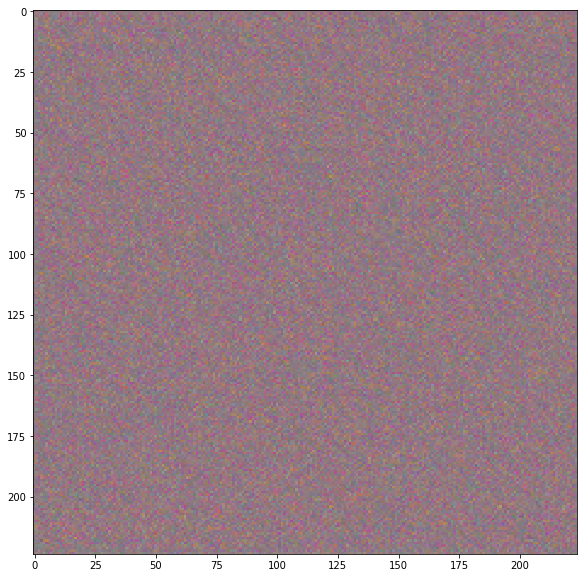

In [11]:
if cuda:
    input = net.make_z().cuda()
else:
    input = net.make_z()
output = net(Variable(input))

if cuda:
    imshow(output.cpu())
else:
    imshow(output)

In [12]:
def test(DIP):
    if cuda:
        temp_z = Variable(DIP.make_z().cuda())
        hr = DIP.hr(temp_z)
        imshow(hr.cpu())
    else:
        temp_z = Variable(DIP.make_z())
        hr = DIP.hr(temp_z)
        imshow(hr)
        
        
def tv_loss(x, beta = 0.5):
    '''Calculates TV loss for an image `x`.
        
    Args:
        x: image, torch.Variable of torch.Tensor
        beta: See https://arxiv.org/abs/1412.0035 (fig. 2) to see effect of `beta` 
    '''
    dh = torch.pow(x[:,:,:,1:] - x[:,:,:,:-1], 2)
    dw = torch.pow(x[:,:,1:,:] - x[:,:,:-1,:], 2)
    
    return torch.sum(torch.pow(dh[:, :, :-1] + dw[:, :, :, :-1], beta))
        
def train(DIP, DOWN, optimizer, criterion, lr_train_img, epoch=100, snaps=50, std=0.01, tv_w=0.0001, tv_beta=1.5):
    DIP.train()
    
    if  cuda:
        lr_train = Variable(
            torch.from_numpy(
                (np.array([lr_train_img]) / 255).transpose((0, 3, 1, 2))
            ).float().cuda()
        )
    else:
        lr_train = Variable(
            torch.from_numpy(
                (np.array([lr_train_img]) / 255).transpose((0, 3, 1, 2))
            ).float()
        )

    DIP_running_loss = 0
    
    if  cuda:
        z = Variable(DIP.make_z().cuda())
    else:
        z = Variable(DIP.make_z())
     
    for j in range(epoch):
      
        z.data += z.data.clone().normal_() * std

        optimizer.zero_grad()

        hr = DIP(z)
        downed = DOWN(hr)
        loss = criterion(downed, lr_train)
        
        loss += tv_w * tv_loss(hr, tv_beta)

        loss.backward()
        optimizer.step()

        DIP_running_loss += loss.data[0]
        
        if ((j + 1) % snaps == 0):
            print("snapshot {} / {}".format(j + 1, epoch))
            if cuda:
                hr = DIP(z)
                imshow(hr.cpu(), (10, 10))
            else:
                hr = DIP(z)
                imshow(hr, (10, 10))
        
    DIP_running_loss /= epoch
        
    print("loss: {}".format(DIP_running_loss))
    
    return DIP_running_loss

In [13]:
DIP_optim = optim.Adam(net.parameters(), 0.01)
criter = nn.MSELoss()
train_img = lr_img

epoch 1 / 1
snapshot 100 / 500


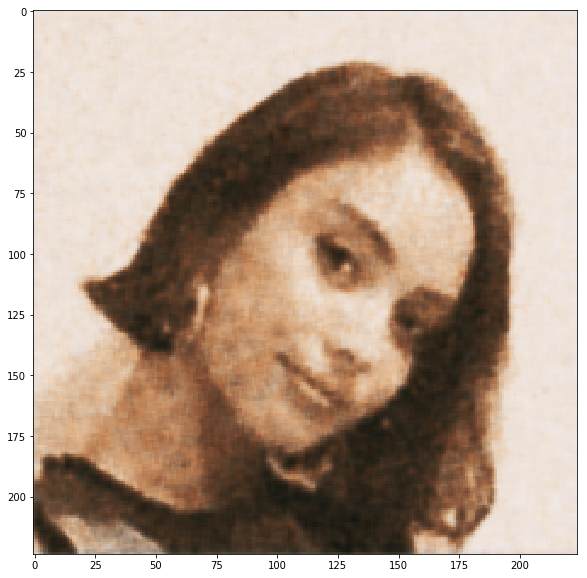

snapshot 200 / 500


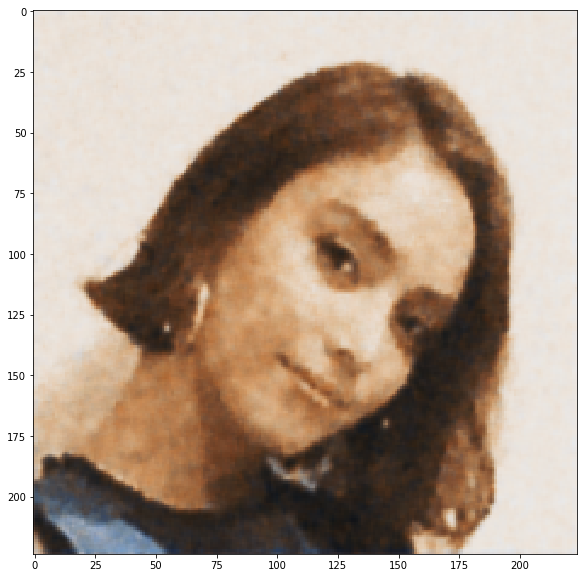

snapshot 300 / 500


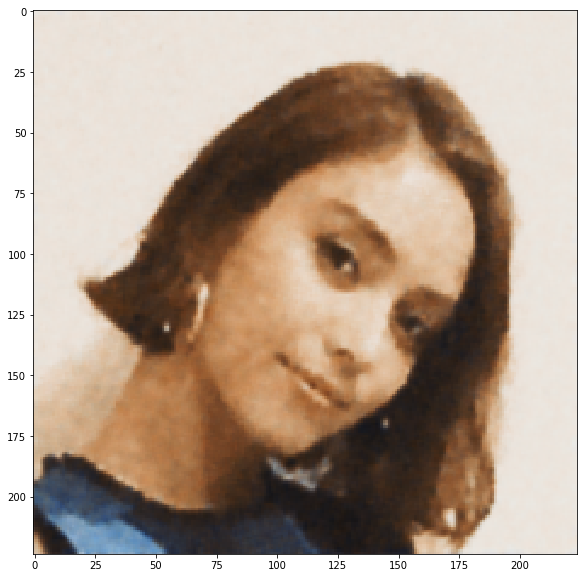

snapshot 400 / 500


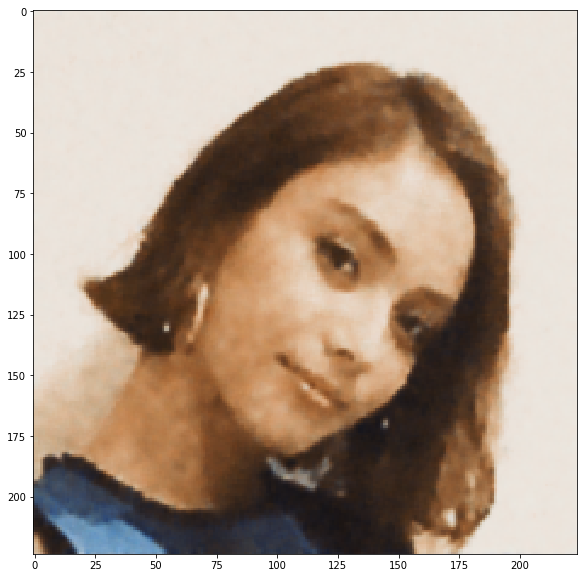

snapshot 500 / 500


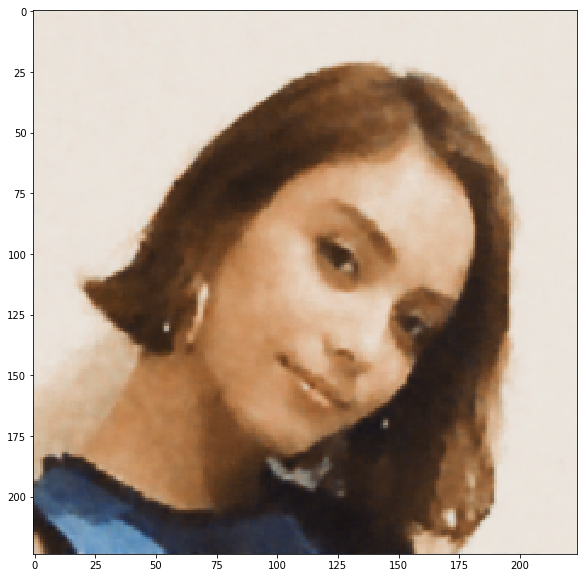

loss: 0.010340038808062673
time : 348.4331736564636


In [16]:
down = DownSampler(2)
down2 = Downsampler(n_planes=3, factor=2, kernel_type='lanczos2', phase=0.5, preserve_size=True)
net = DeepImagePriorSR(32, 112 * 2, 112 * 2, 2)
if cuda:
    net.cuda()
    down2.cuda()

DIP_optim = optim.Adam(net.parameters(), 0.005)
criter = nn.MSELoss()
train_img = lr_img
epochs = 1
times = 3200
snaps = 800
std = 0.01
tv_w=0.000001
tv_beta=0.5
for i in range(epochs):
    start = time.time()
    print("================")
    print("epoch {} / {}".format(i + 1, epochs))
    train(net, down2, DIP_optim, criter, lr_img, times, snaps, std, tv_w, tv_beta)
    print("time : {}".format(time.time() - start))